# Analisis Krisis Ekonomi Negara-Negara Afrika

Notebook ini melakukan:
1. Forecast tingkat inflasi (`inflation_annual_cpi`) setiap negara untuk 15 tahun ke depan.
2. Prediksi kemungkinan terjadinya *banking crisis* untuk 15 tahun ke depan menggunakan model klasifikasi.
3. Klasterisasi negara berdasarkan agregasi (jumlah) `exch_usd` dan `inflation_annual_cpi`.

## Deskripsi Kolom
- `Country`: Nama negara
- `year`: Tahun pengamatan
- `systemic_crisis`: 0/1 ada krisis sistemik
- `exch_usd`: Nilai tukar terhadap USD
- `domestic_debt_in_default`: 0/1 gagal bayar utang domestik
- `sovereign_external_debt_default`: 0/1 gagal bayar utang eksternal
- `gdp_weighted_default`: Rata-rata GDP tertimbang dari default negara lain (indikator)
- `inflation_annual_cpi`: Inflasi tahunan
- `independence`: 0/1 status kemerdekaan
- `currency_crises`: 0/1 krisis mata uang
- `inflation_crises`: 0/1 krisis inflasi (hiperinflasi)
- `banking_crisis`: 'crisis' / 'no_crisis'

## Metodologi Singkat
- Forecast inflasi: `auto_arima` dari pmdarima, fallback ke regresi linier dengan lag jika data pendek.
- Klasifikasi banking crisis: Gradient Boosting + SMOTE, dengan evaluasi ROC AUC & feature importance (surrogate RandomForest).
- Klasterisasi: Sum `exch_usd` dan `inflation_annual_cpi` per negara, scaling, pemilihan k dengan silhouette, KMeans.

Jalankan sel secara berurutan.

In [1]:
# Install libraries tambahan bila belum ada (jalankan sekali)
!pip install pmdarima imbalanced-learn --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Load Dataset
Pastikan file `african_crises.csv` berada di direktori kerja notebook.

In [3]:
df = pd.read_csv('african_crises.csv')
print('Shape awal:', df.shape)
df.head()

Shape awal: (1059, 12)


,Country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Zimbabwe,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,Zimbabwe,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,Zimbabwe,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,Zimbabwe,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,Zimbabwe,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


In [4]:
df.info()
print('\nMissing values per kolom:')
print(df.isna().sum())
print('\nDuplikat:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1059 non-null   object 
 1   year                             1059 non-null   int64  
 2   systemic_crisis                  1059 non-null   int64  
 3   exch_usd                         1059 non-null   float64
 4   domestic_debt_in_default         1059 non-null   int64  
 5   sovereign_external_debt_default  1059 non-null   int64  
 6   gdp_weighted_default             1059 non-null   float64
 7   inflation_annual_cpi             1059 non-null   float64
 8   independence                     1059 non-null   int64  
 9   currency_crises                  1059 non-null   int64  
 10  inflation_crises                 1059 non-null   int64  
 11  banking_crisis                   1059 non-null   object 
dtypes: float64(3), int64

## Cleaning & Preprocessing

In [5]:
# Hapus duplikat
df = df.drop_duplicates()
# Drop rows dengan NA sederhana (bisa diganti imputation jika diperlukan)
df = df.dropna()
# Encode banking crisis ke biner
df['banking_crisis_flag'] = df['banking_crisis'].map({'crisis':1, 'no_crisis':0})
# Sort data
df = df.sort_values(['Country','year']).reset_index(drop=True)
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols

['year',
 'systemic_crisis',
 'exch_usd',
 'domestic_debt_in_default',
 'sovereign_external_debt_default',
 'gdp_weighted_default',
 'inflation_annual_cpi',
 'independence',
 'currency_crises',
 'inflation_crises',
 'banking_crisis_flag']

## Exploratory Data Analysis (EDA)

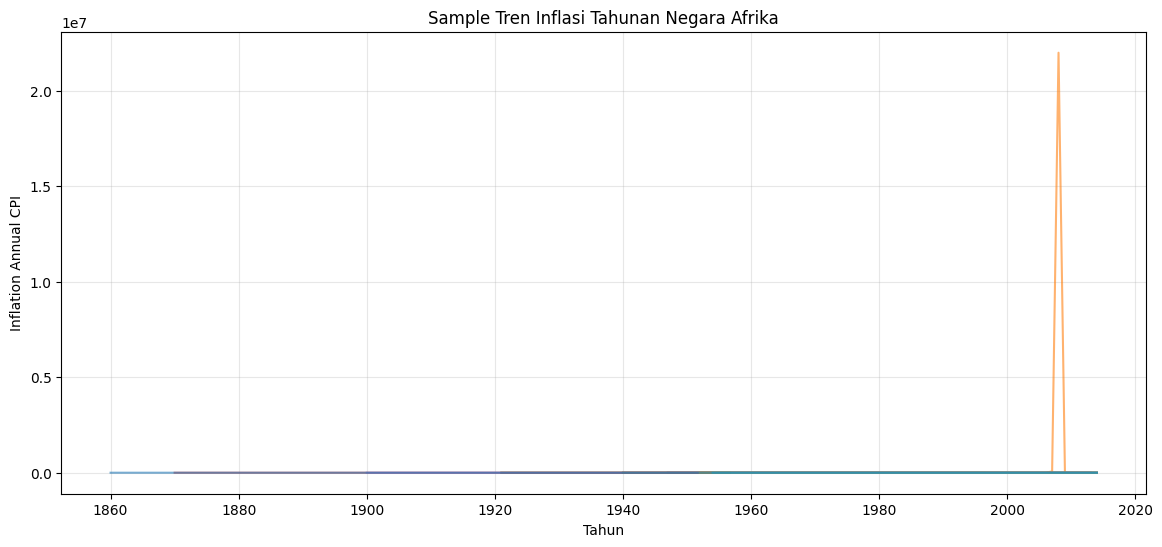

In [6]:
sample_countries = df['Country'].drop_duplicates().sample(min(20, df['Country'].nunique()), random_state=42)
plt.figure(figsize=(14,6))
for c in sample_countries:
    sub = df[df['Country']==c]
    plt.plot(sub['year'], sub['inflation_annual_cpi'], alpha=0.6)
plt.title('Sample Tren Inflasi Tahunan Negara Afrika')
plt.xlabel('Tahun'); plt.ylabel('Inflation Annual CPI')
plt.grid(alpha=0.3)
plt.show()

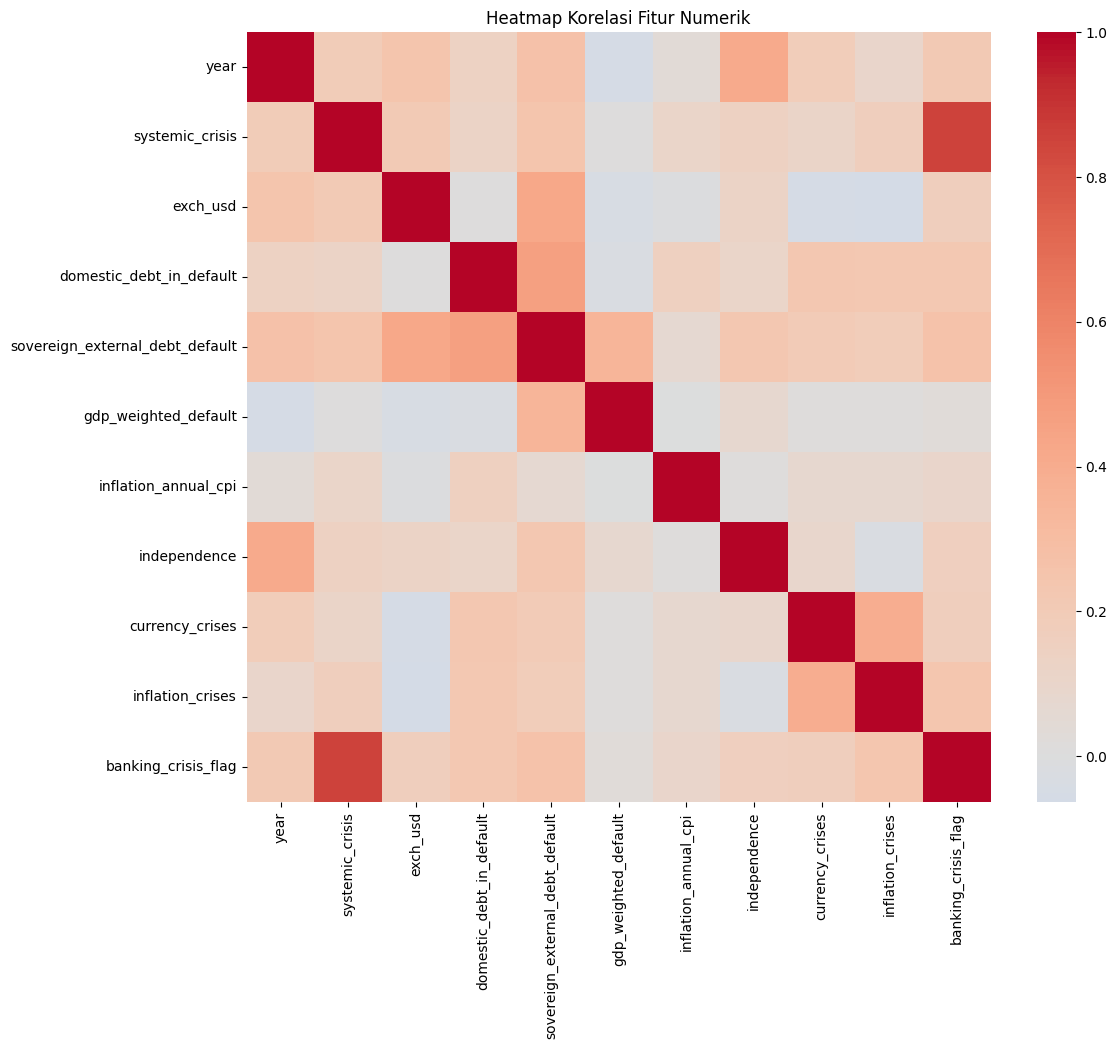

In [7]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

## 1. Forecast Inflasi 15 Tahun ke Depan

In [8]:
def forecast_inflation_country(country_df, horizon=15):
    country_df = country_df.sort_values('year')
    y = country_df['inflation_annual_cpi'].values
    years = country_df['year'].values
    last_year = years[-1]
    future_years = np.arange(last_year+1, last_year+1+horizon)
    forecast_values = None
    model_used = None
    if len(y) > 8:
        try:
            arima_model = pm.auto_arima(y, seasonal=False, stepwise=True, suppress_warnings=True)
            fc = arima_model.predict(n_periods=horizon)
            forecast_values = fc
            model_used = 'auto_arima'
        except Exception as e:
            print(f'ARIMA gagal {country_df.iloc[0]["Country"]}: {e}')
    if forecast_values is None:
        df_temp = pd.DataFrame({'inflation': y})
        for lag in [1,2,3]:
            df_temp[f'lag_{lag}'] = df_temp['inflation'].shift(lag)
        df_temp.dropna(inplace=True)
        X = df_temp.drop('inflation', axis=1).values
        y_reg = df_temp['inflation'].values
        reg = LinearRegression()
        reg.fit(X, y_reg)
        current_lags = df_temp.iloc[-1][['lag_1','lag_2','lag_3']].values
        preds = []
        for _ in range(horizon):
            pred = reg.predict(current_lags.reshape(1,-1))[0]
            preds.append(pred)
            current_lags = np.roll(current_lags, 1)
            current_lags[0] = pred
        forecast_values = np.array(preds)
        model_used = 'linear_regression_lag'
    return pd.DataFrame({
        'Country': country_df.iloc[0]['Country'],
        'year': future_years,
        'inflation_forecast': forecast_values,
        'model': model_used
    })

all_forecasts = []
for c in df['Country'].unique():
    sub = df[df['Country']==c]
    all_forecasts.append(forecast_inflation_country(sub, horizon=15))
forecast_inflation_df = pd.concat(all_forecasts).reset_index(drop=True)
print('Total baris forecast:', forecast_inflation_df.shape)
forecast_inflation_df.head()

Total baris forecast: (165, 4)


,Country,year,inflation_forecast,model
0,Rwanda,2014,0.0,auto_arima
1,Rwanda,2015,0.0,auto_arima
2,Rwanda,2016,0.0,auto_arima
3,Rwanda,2017,0.0,auto_arima
4,Rwanda,2018,0.0,auto_arima


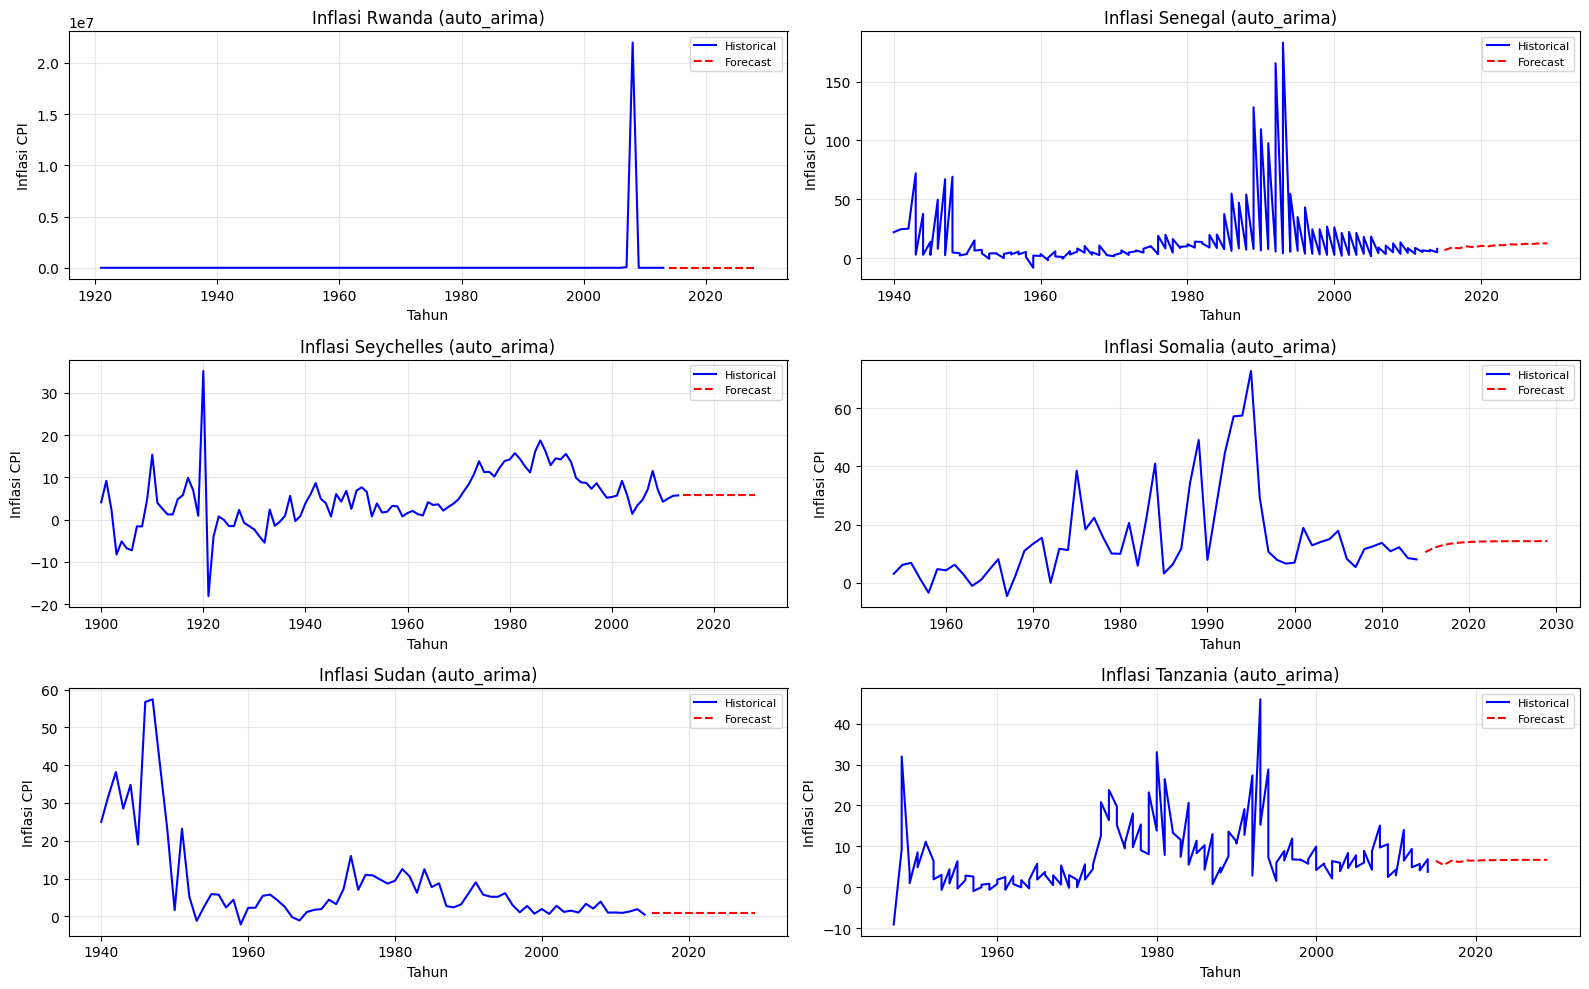

In [9]:
example_countries = forecast_inflation_df['Country'].unique()[:6]
plt.figure(figsize=(16,10))
for i, c in enumerate(example_countries,1):
    plt.subplot(3,2,i)
    hist = df[df['Country']==c]
    fc = forecast_inflation_df[forecast_inflation_df['Country']==c]
    plt.plot(hist['year'], hist['inflation_annual_cpi'], label='Historical', color='blue')
    plt.plot(fc['year'], fc['inflation_forecast'], label='Forecast', color='red', linestyle='--')
    plt.title(f'Inflasi {c} ({fc.iloc[0]["model"]})')
    plt.xlabel('Tahun'); plt.ylabel('Inflasi CPI')
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 2. Model Prediksi Banking Crisis

In [10]:
feature_cols = [
    'systemic_crisis','exch_usd','domestic_debt_in_default','sovereign_external_debt_default',
    'gdp_weighted_default','inflation_annual_cpi','independence','currency_crises','inflation_crises'
]
X = df[feature_cols].copy()
y = df['banking_crisis_flag'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)
gb_model = GradientBoostingClassifier(random_state=42)
pipeline = ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('model', gb_model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feat_imp = pd.DataFrame({'feature':feature_cols,'importance':importances}).sort_values('importance', ascending=False)
feat_imp

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       241
           1       0.92      0.96      0.94        24

    accuracy                           0.99       265
   macro avg       0.96      0.98      0.97       265
weighted avg       0.99      0.99      0.99       265

ROC AUC: 0.9972337482710927


,feature,importance
0,systemic_crisis,0.584586
5,inflation_annual_cpi,0.175054
1,exch_usd,0.154069
3,sovereign_external_debt_default,0.021407
2,domestic_debt_in_default,0.020352
8,inflation_crises,0.018310
7,currency_crises,0.015214
4,gdp_weighted_default,0.005641
6,independence,0.005367


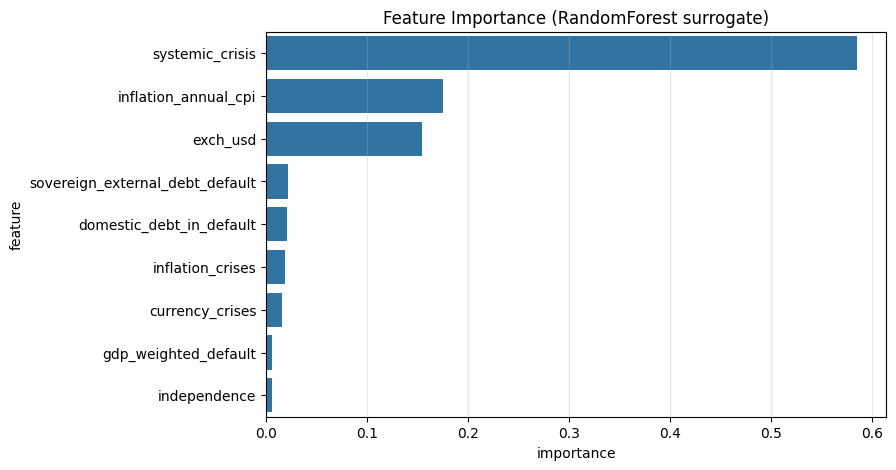

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Feature Importance (RandomForest surrogate)')
plt.grid(axis='x', alpha=0.3)
plt.show()

### Fungsi Prediksi Single Input

In [12]:
def predict_banking_crisis(input_dict, scaler=scaler, model=pipeline):
    row = [input_dict[f] for f in feature_cols]
    row_scaled = scaler.transform([row])
    proba = model.predict_proba(row_scaled)[0][1]
    pred = model.predict(row_scaled)[0]
    return {'prediction': int(pred), 'probability_crisis': float(proba)}

example_input = {
    'systemic_crisis':0,
    'exch_usd':50,
    'domestic_debt_in_default':0,
    'sovereign_external_debt_default':0,
    'gdp_weighted_default':0.1,
    'inflation_annual_cpi':10,
    'independence':1,
    'currency_crises':0,
    'inflation_crises':0
}
predict_banking_crisis(example_input)

{'prediction': 0, 'probability_crisis': 0.06945569597977327}

### Forecast Probabilitas Banking Crisis 15 Tahun (Skenario Baseline)

In [13]:
def future_crisis_prediction(country, inflation_forecasts_df, hist_df, horizon=15):
    hist_country = hist_df[hist_df['Country']==country].sort_values('year')
    recent = hist_country.tail(3)
    baseline = {
        'systemic_crisis': int(recent['systemic_crisis'].median()),
        'exch_usd': recent['exch_usd'].median(),
        'domestic_debt_in_default': int(recent['domestic_debt_in_default'].median()),
        'sovereign_external_debt_default': int(recent['sovereign_external_debt_default'].median()),
        'gdp_weighted_default': recent['gdp_weighted_default'].median(),
        'independence': int(recent['independence'].median()),
        'currency_crises': int(recent['currency_crises'].median()),
        'inflation_crises': int(recent['inflation_crises'].median())
    }
    fc_inf = inflation_forecasts_df[inflation_forecasts_df['Country']==country].head(horizon)
    out_rows = []
    for _, row in fc_inf.iterrows():
        inp = baseline.copy()
        inp['inflation_annual_cpi'] = row['inflation_forecast']
        pred = predict_banking_crisis(inp)
        out_rows.append({
            'Country': country,
            'year': row['year'],
            'inflation_forecast': row['inflation_forecast'],
            'banking_crisis_pred': pred['prediction'],
            'probability_crisis': pred['probability_crisis']
        })
    return pd.DataFrame(out_rows)

all_future_crisis = []
for c in df['Country'].unique():
    all_future_crisis.append(future_crisis_prediction(c, forecast_inflation_df, df, horizon=15))
future_crisis_df = pd.concat(all_future_crisis).reset_index(drop=True)
future_crisis_df.head()

,Country,year,inflation_forecast,banking_crisis_pred,probability_crisis
0,Rwanda,2014,0.0,0,0.007925
1,Rwanda,2015,0.0,0,0.007925
2,Rwanda,2016,0.0,0,0.007925
3,Rwanda,2017,0.0,0,0.007925
4,Rwanda,2018,0.0,0,0.007925


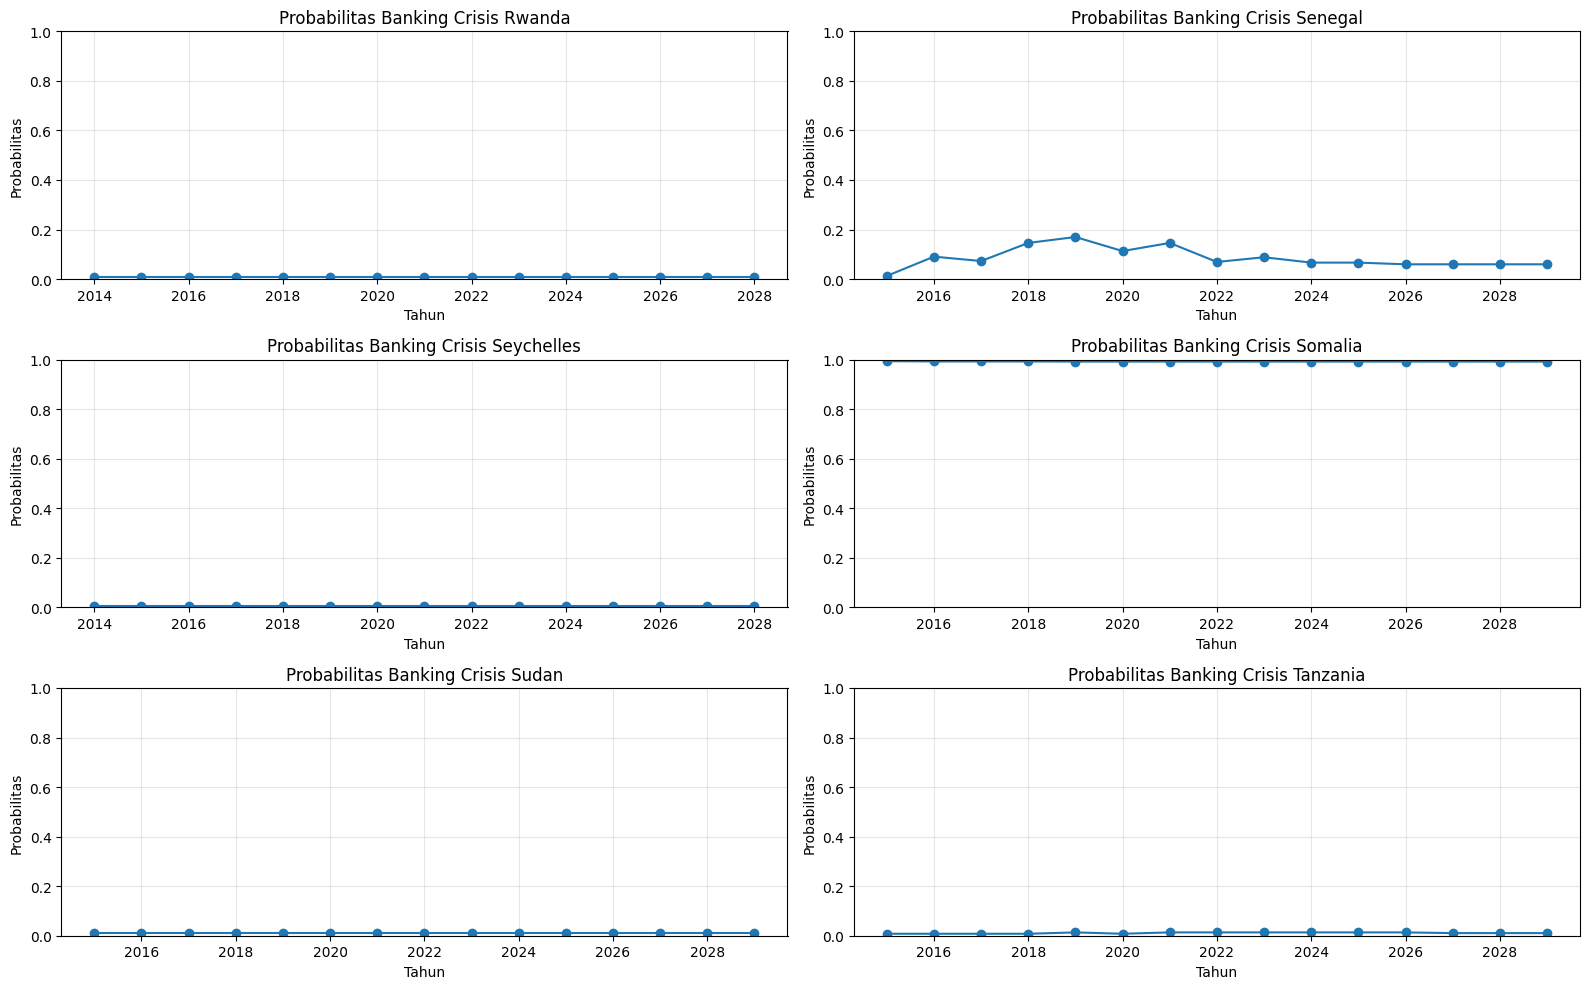

In [14]:
example_countries_bc = future_crisis_df['Country'].unique()[:6]
plt.figure(figsize=(16,10))
for i, c in enumerate(example_countries_bc,1):
    plt.subplot(3,2,i)
    sub = future_crisis_df[future_crisis_df['Country']==c]
    plt.plot(sub['year'], sub['probability_crisis'], marker='o')
    plt.title(f'Probabilitas Banking Crisis {c}')
    plt.xlabel('Tahun'); plt.ylabel('Probabilitas')
    plt.ylim(0,1)
    plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 3. Klasterisasi Negara (Σ exch_usd & Σ inflation_annual_cpi)

In [15]:
agg = df.groupby('Country').agg({'exch_usd':'sum','inflation_annual_cpi':'sum'}).rename(columns={'exch_usd':'sum_exch_usd','inflation_annual_cpi':'sum_inflation_cpi'})
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(agg)
sil_scores = {}
for k in range(2,9):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_cluster)
    sil_scores[k] = silhouette_score(X_cluster, labels)
sil_df = pd.DataFrame({'k':list(sil_scores.keys()), 'silhouette':list(sil_scores.values())})
best_k = sil_df.loc[sil_df['silhouette'].idxmax(),'k']
print(sil_df)
print('Best k:', best_k)
kmeans = KMeans(n_clusters=int(best_k), random_state=42)
agg['cluster'] = kmeans.fit_predict(X_cluster)
agg = agg.reset_index()
agg.head()

   k  silhouette
0  2    0.599994
1  3    0.664133
2  4    0.568665
3  5    0.411444
4  6    0.305295
5  7    0.264816
6  8    0.272022
Best k: 3


,Country,sum_exch_usd,sum_inflation_cpi,cluster
0,Rwanda,1818.702000,2.205950e+07,2
1,Senegal,3882.337163,2.280696e+03,0
2,Seychelles,196.004611,5.917037e+02,0
3,Somalia,2337.061326,8.860117e+02,0
4,Sudan,439.898200,6.510268e+02,0


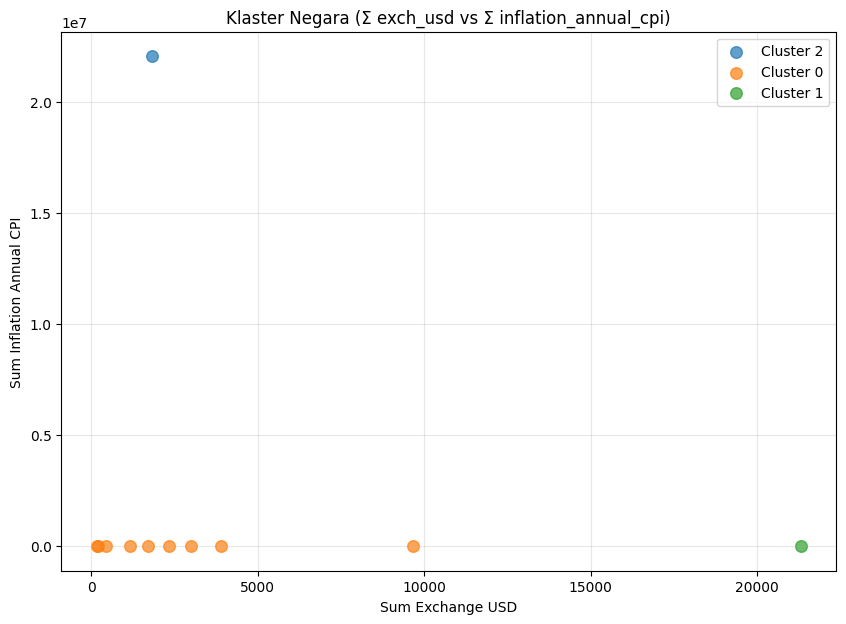

In [16]:
plt.figure(figsize=(10,7))
for cl in agg['cluster'].unique():
    subset = agg[agg['cluster']==cl]
    plt.scatter(subset['sum_exch_usd'], subset['sum_inflation_cpi'], s=70, alpha=0.7, label=f'Cluster {cl}')
plt.title('Klaster Negara (Σ exch_usd vs Σ inflation_annual_cpi)')
plt.xlabel('Sum Exchange USD')
plt.ylabel('Sum Inflation Annual CPI')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [17]:
cluster_groups = agg.groupby('cluster')['Country'].apply(list)
for cl, countries in cluster_groups.items():
    print(f'Cluster {cl}: {len(countries)} negara')
    print(', '.join(countries[:40]))
    print('---')

Cluster 0: 9 negara
Senegal, Seychelles, Somalia, Sudan, Tanzania, Togo, Tunisia, Zambia, Zimbabwe
---
Cluster 1: 1 negara
Uganda
---
Cluster 2: 1 negara
Rwanda
---


## Ringkasan
- Forecast inflasi per negara berhasil dibuat (15 tahun ke depan).
- Model banking crisis dengan Gradient Boosting + SMOTE dievaluasi dan siap dipakai.
- Disediakan fungsi `predict_banking_crisis()` untuk input manual.
- Probabilitas banking crisis masa depan dihitung dengan skenario baseline.
- Klasterisasi negara berdasarkan Σ nilai tukar & Σ inflasi menampilkan segmentasi ekonomi.

## Pengembangan Lanjut
- Gunakan Prophet / VAR untuk multivariate forecasting.
- Tambah skenario (optimis/pesimis) untuk fitur selain inflasi.
- Evaluasi model lain (XGBoost, LightGBM) & tuning hyperparameter.
- Gunakan DBSCAN / GMM untuk alternatif klasterisasi.

Selesai. Silakan modifikasi sesuai kebutuhan.